# Week 2 — GRPO LIS: eval (vLLM)

Этот ноутбук:
- загружает **фиксированные** тестовые наборы (easy/medium/hard) из `data/*.jsonl`
- считает accuracy для:
  - **baseline** `Qwen/Qwen2.5-1.5B-Instruct`
  - **trained** (путь берём из `results/trained_model.json`)
- сохраняет числа в `results/baseline_scores.json` и `results/trained_scores.json`
- строит **парные бары** (baseline vs trained) как в примере matplotlib.

**Важно:** метрики считаются **с тем же `SYSTEM_PROMPT`**, что и в обучении, и инференс делается через **vLLM**.


In [1]:
# Если нужно — установи зависимости в eval-окружении
# !pip install -U vllm transformers datasets accelerate matplotlib

import json
import os
import re
import logging
from pathlib import Path

import matplotlib.pyplot as plt
from datasets import Dataset
from transformers import AutoTokenizer
from vllm import LLM, SamplingParams

# (опционально) приглушить сетевые warning'и (urllib3)
logging.getLogger("urllib3.connectionpool").setLevel(logging.ERROR)


In [ ]:
# --------------------------
# 1) Пути + модели
# --------------------------
import sys
from pathlib import Path

PROJECT_DIR = Path(".").resolve()
if str(PROJECT_DIR) not in sys.path:
    sys.path.insert(0, str(PROJECT_DIR))

DATA_DIR = PROJECT_DIR / "data"
RESULTS_DIR = PROJECT_DIR / "results"

BASE_MODEL = "Qwen/Qwen2.5-1.5B-Instruct"

# SYSTEM_PROMPT должен совпадать с train-ноутбуком (и хранится в w2_utils.py)
from w2_utils import SYSTEM_PROMPT

#CUSTOM_SYSTEM_PROMPT = SYSTEM_PROMPT
CUSTOM_SYSTEM_PROMPT = """Отвечай в следующем формате:
<think>
...
</think>
<answer>
...
</answer>
Output ONLY the integer in <answer> and nothing else.
"""

# trained_model.json создаётся train-ноутбуком: {"trained_model_dir": "..."}
trained_model_json = RESULTS_DIR / "trained_model.json"
if not trained_model_json.exists():
    raise FileNotFoundError(
        f"Не найден {trained_model_json}. Запусти train-ноутбук или создай results/trained_model.json вручную."
    )

TRAINED_MODEL_DIR = json.loads(trained_model_json.read_text(encoding="utf-8"))["trained_model_dir"]
TRAINED_MODEL_DIR = str(TRAINED_MODEL_DIR)

print("PROJECT_DIR:", PROJECT_DIR)
print("DATA_DIR   :", DATA_DIR)
print("RESULTS_DIR:", RESULTS_DIR)
print("BASE_MODEL :", BASE_MODEL)
print("TRAINED_MODEL_DIR:", TRAINED_MODEL_DIR)


PROJECT_DIR: /home/yaros/DS-Mag/AI-SelectedTopics/W2-1
DATA_DIR   : /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/data
RESULTS_DIR: /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results
BASE_MODEL : Qwen/Qwen2.5-1.5B-Instruct
TRAINED_MODEL_DIR: models/qwen2p5_1p5b_grpo_lis_merged


In [3]:
# --------------------------
# 2) Загрузка фиксированных testsets (jsonl)
#    В train-ноутбуке строки сохранялись как {"prompt": ..., "answer": ...}
# --------------------------
from w2_utils import load_jsonl, get_user_prompt

# Подхватываем спецификацию тестов из results/config.json, если она есть
config_json = RESULTS_DIR / "config.json"
if config_json.exists():
    cfg = json.loads(config_json.read_text(encoding="utf-8"))
    test_specs = cfg.get("test_specs", [])
    eval_max_new_tokens = int(cfg.get("eval_max_new_tokens", 64))
    eval_temperature = float(cfg.get("eval_temperature", 0.0))
else:
    cfg = {}
    test_specs = []
    eval_max_new_tokens = 64
    eval_temperature = 0.0

# fallback если config.json не найден или без test_specs
if not test_specs:
    test_specs = [
        {"name": "easy",   "difficulty": 2, "n": 200, "seed": 1001},
        {"name": "medium", "difficulty": 5, "n": 200, "seed": 2001},
        {"name": "hard",   "difficulty": 8, "n": 200, "seed": 3001},
    ]

testsets = {}
for spec in test_specs:
    name = spec["name"]
    p = DATA_DIR / f"test_{name}_d{spec['difficulty']}_n{spec['n']}_seed{spec['seed']}.jsonl"
    if not p.exists():
        raise FileNotFoundError(
            f"Не найден тестовый датасет: {p}\n"
            f"Убедись, что train-ноутбук создал фиксированные тесты в data/."
        )
    rows = load_jsonl(p)
    # sanity check
    _ = get_user_prompt(rows[0])
    _ = rows[0]["answer"]
    testsets[name] = Dataset.from_list(rows)

print("Loaded testsets:", {k: len(v) for k, v in testsets.items()})
print("eval_max_new_tokens =", eval_max_new_tokens)
print("eval_temperature    =", eval_temperature)




Loaded testsets: {'easy': 200, 'medium': 200, 'hard': 200}
eval_max_new_tokens = 64
eval_temperature    = 0.0


In [4]:
# --------------------------
# 3) Prompt builder + extractor
# --------------------------
from w2_utils import build_chat_prompt, extract_int

# Для отладочной статистики (есть ли <answer> тег в ответе)
ANSWER_RE = re.compile(r"<answer>.*<\/answer>", re.IGNORECASE)


In [5]:
# --------------------------
# 4) vLLM: один LLM на модель + оценка на всех датасетах
# --------------------------
from w2_utils import eval_all_testsets_with_llm


In [6]:
# --------------------------
# 5) Запуск eval: baseline vs trained
# --------------------------
# tokenizer используем от BASE_MODEL (после RL он обычно не меняется)
tok = AutoTokenizer.from_pretrained(BASE_MODEL, trust_remote_code=True)
if tok.pad_token is None:
    tok.pad_token = tok.eos_token
gpu_mem_util = 0.3
# baseline LLM
baseline_llm = LLM(
    model=BASE_MODEL,
    tokenizer=BASE_MODEL,
    trust_remote_code=True,
    dtype="auto",
    enforce_eager=True,
    gpu_memory_utilization=gpu_mem_util
)

print("\n=== BASELINE ===")
baseline_scores = eval_all_testsets_with_llm(
    baseline_llm, tok, testsets,
    system_prompt=CUSTOM_SYSTEM_PROMPT,
    max_new_tokens=eval_max_new_tokens,
    temperature=eval_temperature,
)

# Удаляем baseline движок перед созданием trained
# del baseline_llm
# import gc, torch, time
# gc.collect()
# torch.cuda.empty_cache()
# time.sleep(2)

# trained LLM (merged dir)
trained_llm = LLM(
    model=TRAINED_MODEL_DIR,
    tokenizer=BASE_MODEL,
    trust_remote_code=True,
    dtype="auto",
    enforce_eager=True,
    gpu_memory_utilization=gpu_mem_util
)

print("\n=== TRAINED ===")
trained_scores = eval_all_testsets_with_llm(
    trained_llm, tok, testsets,
    system_prompt=CUSTOM_SYSTEM_PROMPT,
    max_new_tokens=eval_max_new_tokens,
    temperature=eval_temperature,
)

RESULTS_DIR.mkdir(parents=True, exist_ok=True)
(RESULTS_DIR / "baseline_scores.json").write_text(json.dumps(baseline_scores, ensure_ascii=False, indent=2), encoding="utf-8")
(RESULTS_DIR / "trained_scores.json").write_text(json.dumps(trained_scores, ensure_ascii=False, indent=2), encoding="utf-8")

print("\nSaved:")
print(" -", RESULTS_DIR / "baseline_scores.json")
print(" -", RESULTS_DIR / "trained_scores.json")


INFO 02-28 17:57:34 [utils.py:223] non-default args: {'tokenizer': 'Qwen/Qwen2.5-1.5B-Instruct', 'trust_remote_code': True, 'gpu_memory_utilization': 0.3, 'disable_log_stats': True, 'enforce_eager': True, 'model': 'Qwen/Qwen2.5-1.5B-Instruct'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 02-28 17:57:36 [model.py:529] Resolved architecture: Qwen2ForCausalLM
INFO 02-28 17:57:36 [model.py:1549] Using max model len 32768
INFO 02-28 17:57:36 [scheduler.py:224] Chunked prefill is enabled with max_num_batched_tokens=16384.
INFO 02-28 17:57:36 [vllm.py:689] Asynchronous scheduling is enabled.
WARNING 02-28 17:57:36 [vllm.py:727] Enforce eager set, overriding optimization level to -O0
INFO 02-28 17:57:36 [vllm.py:845] Cudagraph is disabled under eager mode
WARNING 02-28 17:57:37 [interface.py:456] Using 'pin_memory=False' as WSL is detected. This may slow down the performance.
WARNING 02-28 17:57:37 [system_utils.py:140] We must use the `spawn` multiprocessing start method. Overriding VLLM_WORKER_MULTIPROC_METHOD to 'spawn'. See https://docs.vllm.ai/en/latest/usage/troubleshooting.html#python-multiprocessing for more information. Reasons: WSL is detected and NVML is not compatible with fork
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:40 [core.py:97] Initializing a V1 LLM e

[W228 17:57:52.748554940 socket.cpp:209] [c10d] The hostname of the client socket cannot be retrieved. err=-3


(EngineCore_DP0 pid=25991) INFO 02-28 17:57:52 [parallel_state.py:1445] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, PCP rank 0, TP rank 0, EP rank N/A
(EngineCore_DP0 pid=25991) WARNING 02-28 17:57:52 [interface.py:456] Using 'pin_memory=False' as WSL is detected. This may slow down the performance.
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:52 [gpu_model_runner.py:4124] Starting to load model Qwen/Qwen2.5-1.5B-Instruct...


(EngineCore_DP0 pid=25991) /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/.eval-env/lib/python3.12/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:181: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=25991) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=25991)   warnings.warn(


(EngineCore_DP0 pid=25991) INFO 02-28 17:57:52 [cuda.py:367] Using FLASH_ATTN attention backend out of potential backends: ['FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION'].
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:54 [weight_utils.py:579] No model.safetensors.index.json found in remote.


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.34it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.34it/s]
(EngineCore_DP0 pid=25991) 


(EngineCore_DP0 pid=25991) INFO 02-28 17:57:54 [default_loader.py:293] Loading weights took 0.51 seconds
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:55 [gpu_model_runner.py:4221] Model loading took 2.89 GiB memory and 2.280300 seconds
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:56 [gpu_worker.py:373] Available KV cache memory: 20.2 GiB
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:56 [kv_cache_utils.py:1307] GPU KV cache size: 756,304 tokens
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:56 [kv_cache_utils.py:1312] Maximum concurrency for 32,768 tokens per request: 23.08x
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:56 [kernel_warmup.py:44] Skipping FlashInfer autotune because it is disabled.
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:56 [core.py:278] init engine (profile, create kv cache, warmup model) took 1.52 seconds
(EngineCore_DP0 pid=25991) INFO 02-28 17:57:58 [vllm.py:689] Asynchronous scheduling is enabled.
(EngineCore_DP0 pid=25991) WARNING 02-28 17:57:58 [vllm.py:734] Inductor co

Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[easy] acc=0.0000 (n=200)


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[medium] acc=0.0000 (n=200)


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[hard] acc=0.0050 (n=200)
INFO 02-28 17:58:00 [utils.py:223] non-default args: {'tokenizer': 'Qwen/Qwen2.5-1.5B-Instruct', 'trust_remote_code': True, 'gpu_memory_utilization': 0.3, 'disable_log_stats': True, 'enforce_eager': True, 'model': 'models/qwen2p5_1p5b_grpo_lis_merged'}


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.
The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


INFO 02-28 17:58:00 [model.py:529] Resolved architecture: Qwen2ForCausalLM
INFO 02-28 17:58:00 [model.py:1549] Using max model len 32768
INFO 02-28 17:58:00 [scheduler.py:224] Chunked prefill is enabled with max_num_batched_tokens=16384.
WARNING 02-28 17:58:00 [vllm.py:727] Enforce eager set, overriding optimization level to -O0
INFO 02-28 17:58:00 [vllm.py:845] Cudagraph is disabled under eager mode


The argument `trust_remote_code` is to be used with Auto classes. It has no effect here and is ignored.


(EngineCore_DP0 pid=26319) INFO 02-28 17:58:04 [core.py:97] Initializing a V1 LLM engine (v0.16.0) with config: model='models/qwen2p5_1p5b_grpo_lis_merged', speculative_config=None, tokenizer='Qwen/Qwen2.5-1.5B-Instruct', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, tokenizer_revision=None, trust_remote_code=True, dtype=torch.bfloat16, max_seq_len=32768, download_dir=None, load_format=auto, tensor_parallel_size=1, pipeline_parallel_size=1, data_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=True, enable_return_routed_experts=False, kv_cache_dtype=auto, device_config=cuda, structured_outputs_config=StructuredOutputsConfig(backend='auto', disable_fallback=False, disable_any_whitespace=False, disable_additional_properties=False, reasoning_parser='', reasoning_parser_plugin='', enable_in_reasoning=False), observability_config=ObservabilityConfig(show_hidden_metrics_for_version=None, otlp_traces_endpoint=None, collect_detailed_traces=Non

[W228 17:58:15.937921627 socket.cpp:209] [c10d] The hostname of the client socket cannot be retrieved. err=-3


(EngineCore_DP0 pid=26319) INFO 02-28 17:58:15 [parallel_state.py:1445] rank 0 in world size 1 is assigned as DP rank 0, PP rank 0, PCP rank 0, TP rank 0, EP rank N/A
(EngineCore_DP0 pid=26319) WARNING 02-28 17:58:15 [interface.py:456] Using 'pin_memory=False' as WSL is detected. This may slow down the performance.
(EngineCore_DP0 pid=26319) INFO 02-28 17:58:15 [gpu_model_runner.py:4124] Starting to load model models/qwen2p5_1p5b_grpo_lis_merged...


(EngineCore_DP0 pid=26319) /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/.eval-env/lib/python3.12/site-packages/tvm_ffi/_optional_torch_c_dlpack.py:181: UserWarning: Failed to JIT torch c dlpack extension, EnvTensorAllocator will not be enabled.
(EngineCore_DP0 pid=26319) We recommend installing via `pip install torch-c-dlpack-ext`
(EngineCore_DP0 pid=26319)   warnings.warn(


(EngineCore_DP0 pid=26319) INFO 02-28 17:58:16 [cuda.py:367] Using FLASH_ATTN attention backend out of potential backends: ['FLASH_ATTN', 'FLASHINFER', 'TRITON_ATTN', 'FLEX_ATTENTION'].


Loading safetensors checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.29it/s]
Loading safetensors checkpoint shards: 100% Completed | 1/1 [00:00<00:00,  2.29it/s]
(EngineCore_DP0 pid=26319) 


(EngineCore_DP0 pid=26319) INFO 02-28 17:58:16 [default_loader.py:293] Loading weights took 0.52 seconds
(EngineCore_DP0 pid=26319) INFO 02-28 17:58:17 [gpu_model_runner.py:4221] Model loading took 2.89 GiB memory and 0.857862 seconds
(EngineCore_DP0 pid=26319) INFO 02-28 17:58:18 [gpu_worker.py:373] Available KV cache memory: 20.2 GiB
(EngineCore_DP0 pid=26319) INFO 02-28 17:58:18 [kv_cache_utils.py:1307] GPU KV cache size: 756,304 tokens
(EngineCore_DP0 pid=26319) INFO 02-28 17:58:18 [kv_cache_utils.py:1312] Maximum concurrency for 32,768 tokens per request: 23.08x
(EngineCore_DP0 pid=26319) INFO 02-28 17:58:18 [kernel_warmup.py:44] Skipping FlashInfer autotune because it is disabled.
(EngineCore_DP0 pid=26319) INFO 02-28 17:58:18 [core.py:278] init engine (profile, create kv cache, warmup model) took 1.54 seconds
(EngineCore_DP0 pid=26319) INFO 02-28 17:58:20 [vllm.py:689] Asynchronous scheduling is enabled.
(EngineCore_DP0 pid=26319) WARNING 02-28 17:58:20 [vllm.py:734] Inductor co

Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[easy] acc=0.3650 (n=200)


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[medium] acc=0.1350 (n=200)


Adding requests:   0%|          | 0/200 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/200 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[hard] acc=0.0400 (n=200)

Saved:
 - /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/baseline_scores.json
 - /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/trained_scores.json


In [7]:
# --------------------------
# 6) Числа + дельты (trained - baseline)
# --------------------------
names = list(testsets.keys())
print("\n=== Summary ===")
for n in names:
    b = baseline_scores[n]
    t = trained_scores[n]
    print(f"{n:>8}: baseline={b:.4f} | trained={t:.4f} | delta={t-b:+.4f}")



=== Summary ===
    easy: baseline=0.0000 | trained=0.3650 | delta=+0.3650
  medium: baseline=0.0000 | trained=0.1350 | delta=+0.1350
    hard: baseline=0.0050 | trained=0.0400 | delta=+0.0350


In [8]:
# --------------------------
# 7) DEBUG / sanity-check generation & parsing
# --------------------------
from typing import Any, Dict, List, Optional, Tuple

DEBUG_K = 3
DEBUG_MAX_NEW_TOKENS = 256

def _preview_examples(ds, n: int = 1) -> None:
    n = int(n)
    for i in range(min(n, len(ds))):
        ex = ds[i]
        p = get_user_prompt(ex)
        print("PROMPT (head):", p[:200].replace("\n", " "))
        print("GOLD:", ex.get("answer"))

print("Testset sizes:", {k: len(v) for k, v in testsets.items()})
for name, ds in testsets.items():
    print(f"\n=== {name} sample ===")
    _preview_examples(ds, n=1)

def debug_generate_one(llm, ex: Dict[str, Any], max_new_tokens: int = 128) -> Tuple[Optional[int], str]:
    user_prompt = get_user_prompt(ex)
    prompt_text = build_chat_prompt(tok, user_prompt)

    params = SamplingParams(
        temperature=0.0,
        top_p=1.0,
        max_tokens=int(max_new_tokens),
        #stop=["</answer>"],  # same as eval (can remove stop if you want)
    )
    out_text = llm.generate([prompt_text], params)[0].outputs[0].text
    pred = extract_int(out_text)
    with open("log.txt", "a", encoding="utf-8") as f:
        f.write(out_text + "\n")
        f.write("pred="+ str(pred) + "\n")
    return pred, out_text

def run_debug_on_subset(llm, datasets: Dict[str, Any], model_name: str) -> None:
    print(f"\n===== DEBUG {model_name} =====")
    for ds_name, ds in datasets.items():
        k = min(int(DEBUG_K), len(ds))
        if k <= 0:
            print(f"--- dataset {ds_name}: empty ---")
            continue

        correct = 0
        parsed = 0
        has_tag = 0

        print(f"\n--- dataset {ds_name} (k={k}) ---")
        for i in range(k):
            ex = ds[i]  # IMPORTANT: Dataset[:k] returns dict-of-columns -> BUG. Use index!

            pred, out_text = debug_generate_one(llm, ex, max_new_tokens=DEBUG_MAX_NEW_TOKENS)

            gold_raw = ex.get("answer", None)
            try:
                gold = int(gold_raw) if gold_raw is not None else None
            except Exception:
                gold = None

            ok = (pred is not None and gold is not None and int(pred) == int(gold))
            correct += int(ok)
            parsed  += int(pred is not None)
            has_tag += int(ANSWER_RE.search(out_text) is not None)

            print(f"gold={gold} pred={pred} ok={ok}")
            print("out_tail:", out_text[-320:].replace("\n"," "))

            m = ANSWER_RE.search(out_text)
            print("answer_tag:", m.group(0) if m else None)

        print(f"subset_acc={correct/k:.3f} | parsed_rate={parsed/k:.3f} | has_answer_tag_rate={has_tag/k:.3f}")

# Small sanity-check on real tasks (prints a few generations)
run_debug_on_subset(baseline_llm, testsets, "baseline")
run_debug_on_subset(trained_llm,  testsets, "trained")

# --------------------------
# Extra sanity: evaluate TRAINED on saved dev_*.jsonl from train-notebook (if present)
# --------------------------
dev_files = sorted(DATA_DIR.glob("dev_*.jsonl"))
if dev_files:
    devsets = {p.stem: Dataset.from_list(load_jsonl(p)) for p in dev_files}
    print("\n=== TRAINED on saved dev_* (sanity) ===")
    dev_scores = eval_all_testsets_with_llm(
        trained_llm, tok, devsets,
        system_prompt=CUSTOM_SYSTEM_PROMPT,
        max_new_tokens=eval_max_new_tokens,
        temperature=eval_temperature,
    )
    for name, acc in dev_scores.items():
        print(f"{name}: acc={acc:.4f} (n={len(devsets[name])})")
else:
    print("\n[INFO] No dev_*.jsonl files found in DATA_DIR. Skipping dev sanity eval.")


Testset sizes: {'easy': 200, 'medium': 200, 'hard': 200}

=== easy sample ===
PROMPT (head): You are given a sequence of integers.  Task: compute the length of the Longest Increasing Subsequence (LIS).  Definitions: - A subsequence is obtained by deleting zero or more elements without changin
GOLD: 4

=== medium sample ===
PROMPT (head): You are given a sequence of integers.  Task: compute the length of the Longest Increasing Subsequence (LIS).  Definitions: - A subsequence is obtained by deleting zero or more elements without changin
GOLD: 5

=== hard sample ===
PROMPT (head): You are given a sequence of integers.  Task: compute the length of the Longest Increasing Subsequence (LIS).  Definitions: - A subsequence is obtained by deleting zero or more elements without changin
GOLD: 7

===== DEBUG baseline =====

--- dataset easy (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=4 pred=None ok=False
out_tail: ython def length_of_LIS(sequence):     if not sequence:         return 0          dp = [1] * len(sequence)          for i in range(1, len(sequence)):         for j in range(i):             if sequence[i] > sequence[j]:                 dp[i] = max(dp[i], dp[j] + 1)          return max(dp)  # Example usage sequence = [-8
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=3 pred=4 ok=False
out_tail: y `dp` where `dp[i]` represents the length of the LIS ending with the element at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> - The length of the Longest Increasing Subsequence is 4. </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=4 pred=10 ok=False
out_tail: nt at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The maximum value in the `dp` array will give us the length of the LIS. </think>  <answer> [1, 2, 2, 2, 1, 2, 2, 2, 1, 2] </answer>  The LIS of the given sequence is [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]. The length of this LIS is 10.
answer_tag: None
subset_acc=0.000 | parsed_rate=0.667 | has_answer_tag_rate=0.000

--- dataset medium (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=5 pred=19 ok=False
out_tail:  `dp[i]` represents the length of the LIS ending at index `i`. We iterate through the sequence and update the `dp` array accordingly. The maximum value in the `dp` array will give us the length of the LIS. </think>  <answer> -19, 9, 15, 18, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19, 19 </answer>  The LIS length is 19.
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=6 pred=2 ok=False
out_tail: ray `dp` where `dp[i]` represents the length of the LIS ending at index `i`. We iterate through the sequence and update the `dp` array accordingly. The maximum value in the `dp` array will give us the length of the LIS. </think>  <answer> -20, 20, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2 </answer>  The LIS length is 2.
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=6 pred=-11 ok=False
out_tail: quence (LIS), we can use dynamic programming. We will maintain an array `dp` where `dp[i]` represents the length of the LIS ending at index `i`. We iterate through the sequence and update the `dp` array accordingly. The maximum value in the `dp` array will give us the length of the LIS. </think>  <answer> -11 </answer>
answer_tag: None
subset_acc=0.000 | parsed_rate=1.000 | has_answer_tag_rate=0.000

--- dataset hard (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=None ok=False
out_tail: p` where `dp[i]` represents the length of the LIS ending with the element at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> [2, 3, 3, 4, 4, 4, 4, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5, 5] </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=None ok=False
out_tail: re `dp[i]` represents the length of the LIS ending with the element at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> [1, 1, 2, 3, 3, 3, 4, 4, 4, 4, 4, 5, 5, 5, 6, 6, 6, 6, 6, 6, 7, 7] </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=None ok=False
out_tail: he length of the LIS ending with the element at index `i`. We will iterate through the sequence and update the `dp` array accordingly. The length of the LIS will be the maximum value in the `dp` array. </think>  <answer> -1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1 </answer>  The length of the LIS is 11.
answer_tag: None
subset_acc=0.000 | parsed_rate=0.000 | has_answer_tag_rate=0.000

===== DEBUG trained =====

--- dataset easy (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=4 pred=3 ok=False
out_tail: <answer> 3 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=3 pred=4 ok=False
out_tail: <answer> 4 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is strictly greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=4 pred=4 ok=True
out_tail: <answer> 4 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None
subset_acc=0.333 | parsed_rate=1.000 | has_answer_tag_rate=0.000

--- dataset medium (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=5 pred=4 ok=False
out_tail: <answer> 4 </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=6 pred=4 ok=False
out_tail: <answer> 4 </answer>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=6 pred=4 ok=False
out_tail: LIS), we can use dynamic programming. We will maintain an array `dp` where `dp[i]` represents the length of the LIS ending at index `i`. We iterate through the sequence and for each element, we check all previous elements to see if they can be part of the LIS. If they can, we update the `dp` value accordingly. </think>
answer_tag: None
subset_acc=0.000 | parsed_rate=1.000 | has_answer_tag_rate=0.000

--- dataset hard (k=3) ---


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=4 ok=False
out_tail: <answer> 4 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is strictly greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=4 ok=False
out_tail: <answer> 4 </answer> <think> To find the length of the Longest Increasing Subsequence (LIS), we need to identify the longest subsequence of the given sequence where each element is strictly greater than the previous one. We can use dynamic programming to solve this problem efficiently. </think>
answer_tag: None


Adding requests:   0%|          | 0/1 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/1 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

gold=7 pred=5 ok=False
out_tail: n use dynamic programming. We will maintain an array `dp` where `dp[i]` represents the length of the LIS ending at index `i`. We iterate through the sequence and for each element, we check all previous elements to see if they can be part of an increasing subsequence. If they can, we update `dp[i]` accordingly. </think>
answer_tag: None
subset_acc=0.000 | parsed_rate=1.000 | has_answer_tag_rate=0.000

=== TRAINED on saved dev_* (sanity) ===


Adding requests:   0%|          | 0/128 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/128 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[dev_easy_d2_n128_seed4001] acc=0.3594 (n=128)


Adding requests:   0%|          | 0/128 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/128 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[dev_hard_d8_n128_seed4003] acc=0.0703 (n=128)


Adding requests:   0%|          | 0/128 [00:00<?, ?it/s]

Processed prompts:   0%|          | 0/128 [00:00<?, ?it/s, est. speed input: 0.00 toks/s, output: 0.00 toks/s]

[dev_medium_d5_n128_seed4002] acc=0.1250 (n=128)
dev_easy_d2_n128_seed4001: acc=0.3594 (n=128)
dev_hard_d8_n128_seed4003: acc=0.0703 (n=128)
dev_medium_d5_n128_seed4002: acc=0.1250 (n=128)


In [9]:
# --------------------------
# 7) Парные бары (baseline vs trained) — как в примере matplotlib
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
# --------------------------
from w2_utils import plot_paired_bars_accuracy

out_png = RESULTS_DIR / "paired_bars_accuracy.png"
plot_paired_bars_accuracy(
    baseline_scores,
    trained_scores,
    out_path=out_png,
    title="Accuracy: baseline vs trained",
)

print("Saved plot:", out_png)


Saved plot: /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/paired_bars_accuracy.png


Saved plot: /home/yaros/DS-Mag/AI-SelectedTopics/W2-1/results/paired_bars_accuracy.png


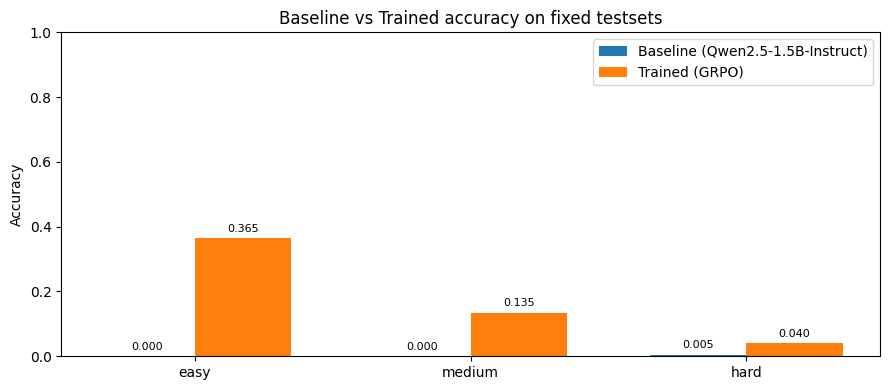

In [10]:
# --------------------------
# 7) Парные бары (baseline vs trained) — как в примере matplotlib
# https://matplotlib.org/stable/gallery/lines_bars_and_markers/barchart.html
# --------------------------
names = list(testsets.keys())
base_vals = [baseline_scores[n] for n in names]
tr_vals = [trained_scores[n] for n in names]

x = list(range(len(names)))
width = 0.35

fig, ax = plt.subplots(figsize=(9, 4))
bars1 = ax.bar([i - width/2 for i in x], base_vals, width, label="Baseline (Qwen2.5-1.5B-Instruct)")
bars2 = ax.bar([i + width/2 for i in x], tr_vals, width, label="Trained (GRPO)")

ax.set_ylabel("Accuracy")
ax.set_title("Baseline vs Trained accuracy on fixed testsets")
ax.set_xticks(x, names)
ax.set_ylim(0.0, 1.0)
ax.legend(loc="best")

def autolabel(rects):
    for r in rects:
        h = r.get_height()
        ax.annotate(
            f"{h:.3f}",
            xy=(r.get_x() + r.get_width() / 2, h),
            xytext=(0, 3),
            textcoords="offset points",
            ha="center",
            va="bottom",
            fontsize=8,
        )

autolabel(bars1)
autolabel(bars2)

fig.tight_layout()
plot_path = RESULTS_DIR / "paired_bars_accuracy.png"
fig.savefig(plot_path, dpi=160)
print("Saved plot:", plot_path)
plt.show()


## Что вставить в отчёт
1) Табличку/список `baseline` vs `trained` + `delta` по easy/medium/hard.  
2) Картинку `results/paired_bars_accuracy.png`.  
3) Пару предложений, где улучшение наиболее заметно и почему (обычно medium/hard выигрывают больше).
